<a href="https://colab.research.google.com/github/lisemureau613/moons_motion/blob/main/UranusFromFITSResnet18_on_my_drive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Moons in motion: object detection for satellites

Authors: L. Mureau (Observatoire de Paris), M. Pasquato (INAF, Milan), D. Souami (Observatoire de Paris) \\
Latest version: 23/08/2025 \\
Correspondence: lise.mureau@gmail.com

Link to full publication:

*Context*: Accurately aligning images of the Uranian system along the planet's center using the ephemerides of the major outer satellites is challenging due to the apparent motion of the latter. Currently, the state-of-the-art approach involves visually inspecting the images and tagging the satellite positions using tools such as DAOPHOT

*Aims*: We aim for a computationally efficient, and easily adjustable algorithm to predict and classify the outer moons present in VLT/NACO images, using a minimalist initial training dataset.

*Methods*: We fine tuned a ResNet-18 framework that was initially trained on ImageNet classification to predict the satellite photo-centres. This relies on only $40$ hand-labelled images, which were automatically augmented to provide sufficient data for our training run.

*Results*: We built a fully automatic pipeline to cross-identify and predict the photo-centre of the outer Uranian satellites in VLT$/$NACO images. The deep learning part of the pipeline identifies satellites and achieves a mean squared error (MSE) in photo-centre prediction of $\sim$$2$ pixels which is improved by automatically calling DOAFIND to refine the result to sub-pixel accuracy.

### First creation of training and testing image folders

* Substitute drive/MyDrive/Uranus/uranus_cropped with your own folder with fits images
* Substitute drive/MyDrive/Uranus/uranus_cropped/labels.csv with your labels
* Run in a colab with GPU support for faster execution

The current notebook, provided images and labels are made for the detection and cross-identification of 3 point sources.





In [3]:
# Mounting to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# creation of training and testing image folders
import os
import random
import shutil
from pathlib import Path

# --- settings ---------------------------------------------------------------
SOURCE_DIR = Path('drive/MyDrive/uranus_cropped')   # your existing folder with FITS files
TRAIN_DIR  = Path('train_fits')                  # will be created LOCALLY
TEST_DIR   = Path('test_fits')                   # will be created LOCALLY
TEST_RATIO = 0.20                                # 20 % of test images

# --- make sure the target folders exist -------------------------------------
TRAIN_DIR.mkdir(exist_ok=True)
TEST_DIR.mkdir(exist_ok=True)

# --- gather *.fits files -----------------------------------------------------
fits_files = [p for p in SOURCE_DIR.iterdir() if p.suffix.lower() == '.fits']

if not fits_files:
    raise RuntimeError(f'No FITS files found in {SOURCE_DIR.resolve()}')

# --- choose test‑set files ---------------------------------------------------
random.seed(42)                   # set a seed for reproducibility (optional)
n_test      = max(1, int(len(fits_files) * TEST_RATIO))
test_sample = set(random.sample(fits_files, n_test))

# --- move the files ----------------------------------------------------------
for f in fits_files:
    target_dir = TEST_DIR if f in test_sample else TRAIN_DIR
    shutil.copy2(str(f), target_dir / f.name)

print(f'Copied {n_test} files to {TEST_DIR}, {len(fits_files) - n_test} to {TRAIN_DIR}')


Copied 28 files to test_fits, 116 to train_fits


### Then augmentation of the images in train and creation of correct labels for the augmented images

You can tweak the parameters below.
N_AUG decides how many images create for each training image.
SHIFT_PERCENT decides the maximum amount by how much to shift

In [5]:
# ---------------------------------------------------------------
#  FITS  data-augmentation  with correct key-point transformation
#  (rotation ±15°, zoom 0.9-1.1×, shift ±15 % frame size)
# ---------------------------------------------------------------
import random, cv2, numpy as np, pandas as pd
from pathlib import Path
from astropy.io import fits

# ---------- configuration ----------
SOURCE_LABELS = Path('drive/MyDrive/uranus_cropped/3_key_label_N10.txt')
TRAIN_DIR     = Path('train_fits')   # originals + where augmented FITS go
TEST_DIR      = Path('test_fits')    # untouched test set
N_AUG         = 50                   # copies per training image
SHIFT_PERC    = 0.15                 # ±15 % shift
ROT_DEG       = 15                   # ±15° rotation
ZOOM_RANGE    = (0.9, 1.1)           # 0.9–1.1×
SEED          = 888                  # reproducible
# -----------------------------------

random.seed(SEED)
np.random.seed(SEED)

# ---------- load & split labels ----------
df_all  = pd.read_csv(SOURCE_LABELS, sep=' ')      # space-separated
test_set = {p.name for p in TEST_DIR.iterdir()}

df_test  = df_all[df_all['filename'].isin(test_set)].reset_index(drop=True)
df_train = df_all[~df_all['filename'].isin(test_set)].reset_index(drop=True)

# ---------- augmentation helper ----------
def augment_fits(row, aug_idx):
    """Returns a new row dict and writes the augmented FITS file."""
    src_path = TRAIN_DIR / row['filename']
    if not src_path.exists():
        raise FileNotFoundError(src_path)

    with fits.open(src_path) as h:
        img  = h[0].data.astype(np.float32)
        hdr  = h[0].header.copy()

    h_px, w_px = img.shape
    cx, cy = w_px / 2, h_px / 2

    # random transform parameters
    dx    = random.uniform(-SHIFT_PERC * w_px,  SHIFT_PERC * w_px)
    dy    = random.uniform(-SHIFT_PERC * h_px,  SHIFT_PERC * h_px)
    angle = random.uniform(-ROT_DEG, ROT_DEG)           # °, CCW (+) in OpenCV
    zoom  = random.uniform(*ZOOM_RANGE)

    # 2×3 forward affine matrix (rotation + scale about centre, then shift)
    M = cv2.getRotationMatrix2D((cx, cy), angle, zoom)   # returns float64
    M[0, 2] += dx
    M[1, 2] += dy
    M = M.astype(np.float32)                             # cv2 prefers float32

    # warp image
    aug_img = cv2.warpAffine(
        img,
        M,
        (w_px, h_px),
        flags=cv2.INTER_CUBIC,
        borderMode=cv2.BORDER_REFLECT,
    )

    # transform key-points
    def tf(x, y):
        vec = M @ np.array([x, y, 1], dtype=np.float32)
        return float(vec[0]), float(vec[1])

    x1, y1 = tf(row.x1, row.y1)
    x2, y2 = tf(row.x2, row.y2)
    x3, y3 = tf(row.x3, row.y3)

    # write new FITS file
    new_name = f"{src_path.stem}_aug{aug_idx}.fits"
    fits.writeto(TRAIN_DIR / new_name, aug_img, header=hdr, overwrite=True)

    return {
        'filename': new_name,
        'x1': x1, 'y1': y1,
        'x2': x2, 'y2': y2,
        'x3': x3, 'y3': y3,
    }

# ---------- run augmentations ----------
aug_rows = []
for _, r in df_train.iterrows():
    for k in range(1, N_AUG + 1):
        aug_rows.append(augment_fits(r, k))

df_train_aug = pd.concat([df_train, pd.DataFrame(aug_rows)], ignore_index=True)

# ---------- save label files ----------
df_train_aug.to_csv('labels_train.csv', index=False)
df_test.to_csv('labels_test.csv',   index=False)

print(f"✅  Created {len(aug_rows)} augmented FITS images in {TRAIN_DIR}")
print("   Wrote labels_train.csv and labels_test.csv")


✅  Created 1550 augmented FITS images in train_fits
   Wrote labels_train.csv and labels_test.csv


### After augmenting, the deep learning part


In [6]:
# ──────────────────────────────────────────────────────────────────────────────
# 0.  Setup  (should install without errors)
# ──────────────────────────────────────────────────────────────────────────────
!pip install -q torch torchvision tqdm --upgrade

In [7]:
# to hide the display of errors and comments during the training
# (to comment for debugging)
import sys

class NullWriter:
    def write(self, _): pass
    def flush(self): pass

sys.stderr = NullWriter()

In [ ]:
# resnet18_fits_keypoints.py
# ---------------------------------------------------------------------------
# Key‑point regression on FITS images using a ResNet‑18 backbone pretrained on
# ImageNet. Keeps the original data pipeline, evaluation metrics, and plotting
# utilities from the ResNet‑9 version.
# ---------------------------------------------------------------------------

import math, random, cv2, torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm.auto import tqdm
from astropy.io import fits  # FITS reader

# ─────────────────────────────── paths & hyper‑params ───────────────────────────────
TRAIN_DIR = Path("train_fits")
TEST_DIR  = Path("test_fits")
CSV_TRAIN = Path("labels_train.csv")
CSV_TEST  = Path("labels_test.csv")

BATCH_SIZE   = 32
EPOCHS_HEAD  = 20      # warm‑up epochs (fc layer only)
EPOCHS_FULL  = 30     # fine‑tune epochs (full network)
LR           = 0.001
IMG_SIZE     = 224

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", DEVICE)

# ─────────────────────────────── dataset class ───────────────────────────────
class KPDataset(Dataset):
    """Key‑point dataset that reads images from FITS/PNG/JPG and outputs:
       * image   → FloatTensor shape (3, IMG_SIZE, IMG_SIZE)
       * key‑pts → FloatTensor [x1,y1,x2,y2,x3,y3] in relative coords 0‑1
    """

    def __init__(self, csv_file: Path, root_dir: Path, augment: bool = False):
        self.df   = pd.read_csv(csv_file)
        self.root = Path(root_dir)
        self.aug  = augment

        self.tfs = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225]),
        ])

    # ---------------------------------------------------------------------
    @staticmethod
    def _read_fits(path: Path) -> np.ndarray:
        """Load a FITS file → pseudo‑RGB uint8 array (H×W×3)."""
        with fits.open(path, memmap=False) as hdul:
            data = hdul[0].data.astype(np.float32)

        # Scale 0‑1, handle NaNs, stretch to 0‑255 uint8
        data = np.nan_to_num(data, nan=0.0)
        data -= data.min()
        if data.max() > 0:
            data /= data.max()
        data = (data * 255).clip(0, 255).astype(np.uint8)

        # FITS is single channel – replicate to 3‑channel pseudo‑RGB
        return np.stack([data, data, data], axis=-1)

    # ---------------------------------------------------------------------
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row      = self.df.iloc[idx]
        img_path = self.root / row["filename"]

        # Load image (FITS or raster)
        if img_path.suffix.lower() == ".fits":
            img = self._read_fits(img_path)
        else:
            img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)

        h, w = img.shape[:2]

        # relative key‑points [0‑1]
        kps = torch.tensor([
            row["x1"] / w, row["y1"] / h,
            row["x2"] / w, row["y2"] / h,
            row["x3"] / w, row["y3"] / h,
        ], dtype=torch.float32)

        # Simple colour jitter (works on replicated RGB too)
        if self.aug and random.random() < 0.5:
            img = cv2.convertScaleAbs(
                img,
                alpha=random.uniform(0.9, 1.1),
                beta=random.randint(-10, 10),
            )

        return self.tfs(img), kps

# ─────────────────────────── data‑loaders ───────────────────────────
train_ds = KPDataset(CSV_TRAIN, TRAIN_DIR, augment=True)
valid_ds = KPDataset(CSV_TEST,  TEST_DIR,  augment=False)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                      num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=2, pin_memory=True)

# ─────────────────────────── model definition ───────────────────────────
def get_model(num_outputs: int = 6, pretrained: bool = True) -> nn.Module:
    """Return ResNet‑18 modified for key‑point regression."""
    # torchvision >= 0.13 uses Weights API; fall back if older
    try:
        weights = models.ResNet18_Weights.IMAGENET1K_V1 if pretrained else None
        model   = models.resnet18(weights=weights)
    except AttributeError:
        model = models.resnet18(pretrained=pretrained)

    # Replace classification head with regression head
    num_ftrs   = model.fc.in_features
    model.fc   = nn.Linear(num_ftrs, num_outputs)
    return model

model = get_model().to(DEVICE)

# ──────────────────────── training utilities ────────────────────────
loss_fn = nn.MSELoss()


def train_one_epoch(loader, net, optim, criterion):
    net.train()
    epoch_loss = 0.0
    for x, y in tqdm(loader, leave=False):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optim.zero_grad()
        pred  = net(x)
        loss  = criterion(pred, y)
        loss.backward()
        optim.step()
        epoch_loss += loss.item() * x.size(0)
    return epoch_loss / len(loader.dataset)


@torch.no_grad()
def evaluate_pixel_err(loader, net):
    net.eval()
    total, n = 0.0, 0
    scale = torch.tensor([IMG_SIZE, IMG_SIZE] * 3, device=DEVICE)
    for x, y in loader:
        x, y       = x.to(DEVICE), y.to(DEVICE)
        pred_px    = net(x).clamp(0, 1) * scale
        target_px  = y * scale
        dist       = torch.sqrt(((pred_px - target_px).reshape(-1, 3, 2) ** 2).sum(-1)).mean(-1)
        total     += dist.sum().item()
        n         += dist.numel()
    return total / n


@torch.no_grad()
def evaluate_loss(loader, net, criterion):
    net.eval()
    running = 0.0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        running += criterion(net(x), y).item() * x.size(0)
    return running / len(loader.dataset)

# ──────────────────────────── optimization ────────────────────────────
train_losses_head, train_losses_full = [], []
val_losses, val_errors = [], []

# 1. Train head (Optionally)
if EPOCHS_HEAD > 0:
    for p in model.parameters():
        p.requires_grad = False
    for p in model.fc.parameters():
        p.requires_grad = True

    optim = torch.optim.Adam(model.fc.parameters(), lr=LR)

    for epoch in range(EPOCHS_HEAD):
        tr_loss = train_one_epoch(train_dl, model, optim, loss_fn)
        train_losses_head.append(tr_loss)
        print(f"[head] epoch {epoch+1}/{EPOCHS_HEAD} – train MSE: {tr_loss:.4f}")

# 2. Fine‑tune full network
for p in model.parameters():
    p.requires_grad = True
optim = torch.optim.Adam(model.parameters(), lr=LR / 10)

for epoch in range(EPOCHS_FULL):
    tr_loss = train_one_epoch(train_dl, model, optim, loss_fn)
    train_losses_full.append(tr_loss)

    val_loss = evaluate_loss(valid_dl, model, loss_fn)
    val_err  = evaluate_pixel_err(valid_dl, model)
    val_losses.append(val_loss)
    val_errors.append(val_err)

    print(f"[full] epoch {epoch+1}/{EPOCHS_FULL} – "
          f"train MSE: {tr_loss:.4f} – val MSE: {val_loss:.4f} – "
          f"val pixel error: {val_err:.2f}")

# ──────────────────────────── final eval & save ────────────────────────────
mean_px_err = evaluate_pixel_err(valid_dl, model)
print(f"\n🔍 Mean Euclidean error on test set: {mean_px_err:.2f} pixels")

torch.save(model.state_dict(), "resnet18_kp.pth")
print("Model weights saved to resnet18_kp.pth")

# ──────────────────────────────── plots ────────────────────────────────
plt.figure(figsize=(10, 5))

epochs_head = list(range(1, EPOCHS_HEAD + 1))
epochs_full = list(range(EPOCHS_HEAD + 1, EPOCHS_HEAD + EPOCHS_FULL + 1))

if train_losses_head:
    plt.plot(epochs_head, train_losses_head, label="Train Loss (Head Only)")
plt.plot(epochs_full, train_losses_full, label="Train Loss (Fine‑tune)")
plt.plot(epochs_full, val_losses, label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Using cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0/50 [00:00<?, ?it/s]

[head] epoch 1/20 – train MSE: 0.1030


  0%|          | 0/50 [00:00<?, ?it/s]

[head] epoch 2/20 – train MSE: 0.0404


  0%|          | 0/50 [00:00<?, ?it/s]

[head] epoch 3/20 – train MSE: 0.0295


  0%|          | 0/50 [00:00<?, ?it/s]

[head] epoch 4/20 – train MSE: 0.0231


  0%|          | 0/50 [00:00<?, ?it/s]

[head] epoch 5/20 – train MSE: 0.0187


  0%|          | 0/50 [00:00<?, ?it/s]

[head] epoch 6/20 – train MSE: 0.0171


  0%|          | 0/50 [00:00<?, ?it/s]

[head] epoch 7/20 – train MSE: 0.0134


  0%|          | 0/50 [00:00<?, ?it/s]

[head] epoch 8/20 – train MSE: 0.0132


  0%|          | 0/50 [00:00<?, ?it/s]

[head] epoch 9/20 – train MSE: 0.0117


  0%|          | 0/50 [00:00<?, ?it/s]

[head] epoch 10/20 – train MSE: 0.0105


  0%|          | 0/50 [00:00<?, ?it/s]

[head] epoch 11/20 – train MSE: 0.0097


  0%|          | 0/50 [00:00<?, ?it/s]

[head] epoch 12/20 – train MSE: 0.0085


  0%|          | 0/50 [00:00<?, ?it/s]

[head] epoch 13/20 – train MSE: 0.0086


  0%|          | 0/50 [00:00<?, ?it/s]

[head] epoch 14/20 – train MSE: 0.0092


  0%|          | 0/50 [00:00<?, ?it/s]

[head] epoch 15/20 – train MSE: 0.0079


  0%|          | 0/50 [00:00<?, ?it/s]

[head] epoch 16/20 – train MSE: 0.0079


  0%|          | 0/50 [00:00<?, ?it/s]

[head] epoch 17/20 – train MSE: 0.0072


  0%|          | 0/50 [00:00<?, ?it/s]

[head] epoch 18/20 – train MSE: 0.0073


  0%|          | 0/50 [00:00<?, ?it/s]

[head] epoch 19/20 – train MSE: 0.0069


  0%|          | 0/50 [00:00<?, ?it/s]

[head] epoch 20/20 – train MSE: 0.0062


  0%|          | 0/50 [00:00<?, ?it/s]

[full] epoch 1/30 – train MSE: 0.0061 – val MSE: 0.0017 – val pixel error: 11.49


  0%|          | 0/50 [00:00<?, ?it/s]

[full] epoch 2/30 – train MSE: 0.0024 – val MSE: 0.0010 – val pixel error: 8.65


  0%|          | 0/50 [00:00<?, ?it/s]

[full] epoch 3/30 – train MSE: 0.0012 – val MSE: 0.0005 – val pixel error: 6.64


  0%|          | 0/50 [00:00<?, ?it/s]

[full] epoch 4/30 – train MSE: 0.0009 – val MSE: 0.0004 – val pixel error: 5.36


  0%|          | 0/50 [00:00<?, ?it/s]

[full] epoch 5/30 – train MSE: 0.0008 – val MSE: 0.0002 – val pixel error: 3.82


  0%|          | 0/50 [00:00<?, ?it/s]

[full] epoch 6/30 – train MSE: 0.0005 – val MSE: 0.0003 – val pixel error: 5.31


  0%|          | 0/50 [00:00<?, ?it/s]

[full] epoch 7/30 – train MSE: 0.0005 – val MSE: 0.0005 – val pixel error: 6.56


  0%|          | 0/50 [00:00<?, ?it/s]

[full] epoch 8/30 – train MSE: 0.0004 – val MSE: 0.0002 – val pixel error: 4.48


  0%|          | 0/50 [00:00<?, ?it/s]

[full] epoch 9/30 – train MSE: 0.0005 – val MSE: 0.0003 – val pixel error: 5.02


  0%|          | 0/50 [00:00<?, ?it/s]

[full] epoch 10/30 – train MSE: 0.0004 – val MSE: 0.0003 – val pixel error: 4.79


  0%|          | 0/50 [00:00<?, ?it/s]

[full] epoch 11/30 – train MSE: 0.0004 – val MSE: 0.0002 – val pixel error: 3.48


  0%|          | 0/50 [00:00<?, ?it/s]

[full] epoch 12/30 – train MSE: 0.0003 – val MSE: 0.0001 – val pixel error: 2.99


  0%|          | 0/50 [00:00<?, ?it/s]

[full] epoch 13/30 – train MSE: 0.0002 – val MSE: 0.0001 – val pixel error: 2.33


  0%|          | 0/50 [00:00<?, ?it/s]

[full] epoch 14/30 – train MSE: 0.0002 – val MSE: 0.0001 – val pixel error: 3.22


  0%|          | 0/50 [00:00<?, ?it/s]

[full] epoch 15/30 – train MSE: 0.0003 – val MSE: 0.0001 – val pixel error: 3.35


  0%|          | 0/50 [00:00<?, ?it/s]

[full] epoch 16/30 – train MSE: 0.0002 – val MSE: 0.0001 – val pixel error: 3.03


  0%|          | 0/50 [00:00<?, ?it/s]

[full] epoch 17/30 – train MSE: 0.0002 – val MSE: 0.0001 – val pixel error: 2.81


  0%|          | 0/50 [00:00<?, ?it/s]

[full] epoch 18/30 – train MSE: 0.0002 – val MSE: 0.0002 – val pixel error: 3.80


  0%|          | 0/50 [00:00<?, ?it/s]

[full] epoch 19/30 – train MSE: 0.0002 – val MSE: 0.0001 – val pixel error: 2.24


  0%|          | 0/50 [00:00<?, ?it/s]

[full] epoch 20/30 – train MSE: 0.0001 – val MSE: 0.0002 – val pixel error: 3.90


  0%|          | 0/50 [00:00<?, ?it/s]

[full] epoch 21/30 – train MSE: 0.0002 – val MSE: 0.0001 – val pixel error: 2.83


  0%|          | 0/50 [00:00<?, ?it/s]

[full] epoch 22/30 – train MSE: 0.0002 – val MSE: 0.0002 – val pixel error: 3.87


  0%|          | 0/50 [00:00<?, ?it/s]

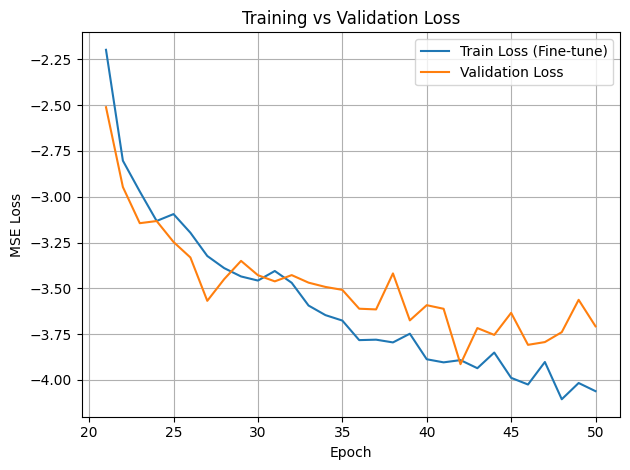

In [ ]:
# Display of training and validation loss
plt.plot(epochs_full, np.log10(train_losses_full), label="Train Loss (Fine‑tune)")
plt.plot(epochs_full, np.log10(val_losses), label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

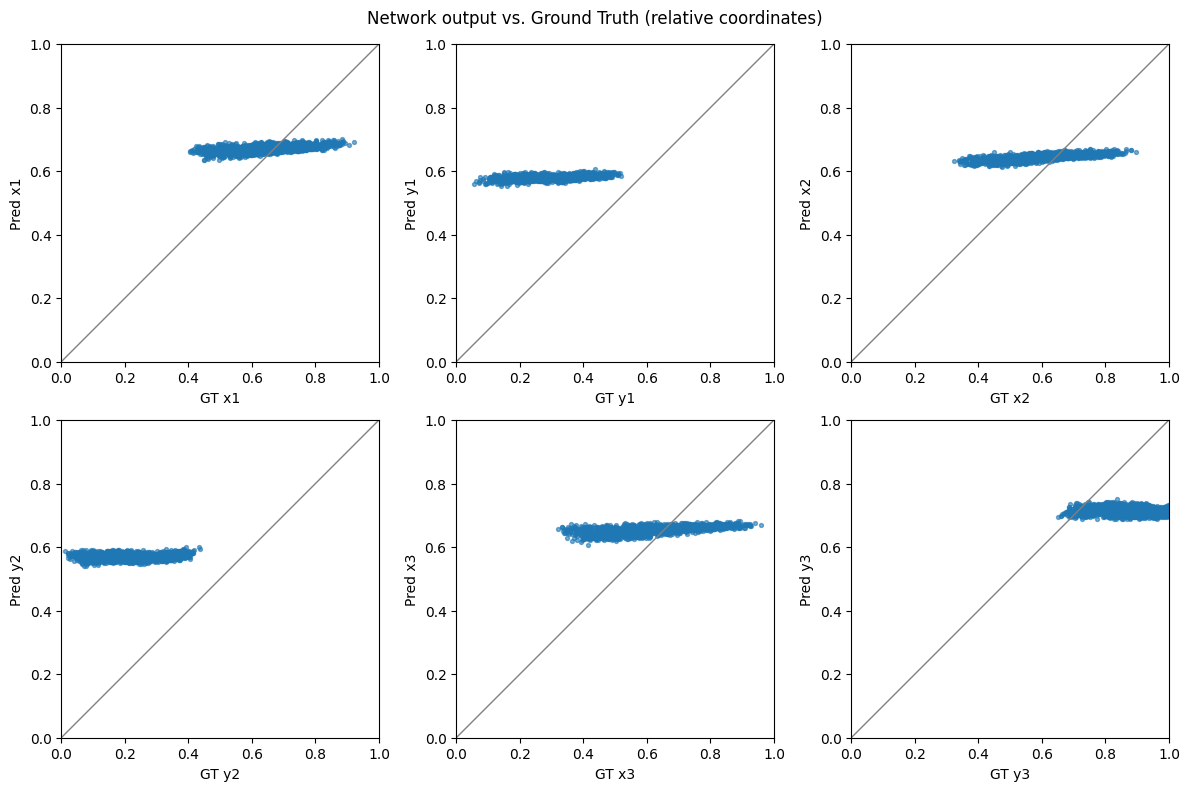

In [ ]:
# ---------------------------------------------------------------
#   P r e d i c t i o n   v s .   G r o u n d  T r u t h
#   six scatter-plots  (x1, y1, x2, y2, x3, y3)  in relative [0-1]
# ---------------------------------------------------------------
import cv2, torch, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from astropy.io import fits
from torchvision import models
from torch import nn

# ---------- paths -------------------------------------------------------
LABELS_FILE = Path('labels_train.csv')
TEST_DIR    = Path('train_fits')
WEIGHTS     = Path('resnet18_kp.pth')
IMG_SIZE    = 224           # model input
# ------------------------------------------------------------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mean   = torch.tensor([0.485,0.456,0.406], dtype=torch.float32, device=device)
std    = torch.tensor([0.229,0.224,0.225], dtype=torch.float32, device=device)

# ---------- build model -------------------------------------------------
ckpt = torch.load(WEIGHTS, map_location='cpu')
net  = models.resnet18(weights=None, num_classes=6)
if any(k.startswith('fc.0.') for k in ckpt):       # Linear→Sigmoid
    net.fc, need_sig = nn.Sequential(nn.Linear(net.fc.in_features, 6), nn.Sigmoid()), False
else:                                              # Linear only
    net.fc, need_sig = nn.Linear(net.fc.in_features, 6), True
net.load_state_dict(ckpt, strict=False)
net = net.to(device).eval()

# ---------- helper ------------------------------------------------------
def fits_to_tensor(path):
    with fits.open(path, memmap=False) as h:
        img = h[0].data.astype(np.float32)
    # centre-stretch for network: normalise 0-1 & to 8-bit RGB
    vmin, vmax = np.percentile(img, (0.5, 99.5))
    img = np.clip((img - vmin) / (vmax - vmin + 1e-6), 0, 1)
    img = (img * 255).astype(np.uint8)
    img = np.repeat(img[..., None], 3, axis=-1)           # pseudo-RGB
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    x = torch.from_numpy(img).permute(2,0,1).float().to(device) / 255.  # move first
    x = (x - mean[:, None, None]) / std[:, None, None]
    return x.unsqueeze(0).to(device)                      # (1,3,224,224)

# ---------- run inference over test set -------------------------------
gt_all, pred_all = [], []

df = pd.read_csv(LABELS_FILE)
for _, row in df.iterrows():
    path = TEST_DIR / row.filename
    if not path.exists(): continue

    # --- prediction (relative 0-1) ---
    with torch.no_grad():
        out = net(fits_to_tensor(path))
        if need_sig: out = out.sigmoid()
    pred_all.append(out.squeeze().cpu().numpy())

    # --- ground truth ---------------
    coords = row[['x1','y1','x2','y2','x3','y3']].to_numpy(float)
    if coords.max() > 1.01:               # stored as absolute → make relative
        with fits.open(path, memmap=False) as h:
            h_px, w_px = h[0].data.shape
        coords[0::2] /= w_px              # x coords
        coords[1::2] /= h_px              # y coords
    gt_all.append(coords)

gt_all   = np.vstack(gt_all)
pred_all = np.vstack(pred_all)

# ---------- scatter-plots ---------------------------------------------
labels = ['x1','y1','x2','y2','x3','y3']
fig, axes = plt.subplots(2,3, figsize=(12,8))
for i, ax in enumerate(axes.flat):
    ax.scatter(gt_all[:,i], pred_all[:,i], s=8, alpha=0.6)
    ax.plot([0,1], [0,1], color='grey', lw=1)    # y = x reference
    ax.set_xlabel(f'GT {labels[i]}')
    ax.set_ylabel(f'Pred {labels[i]}')
    ax.set_xlim(0,1); ax.set_ylim(0,1)
    ax.set_aspect('equal', 'box')
fig.suptitle('Network output vs. Ground Truth (relative coordinates)')
plt.tight_layout()
plt.show()


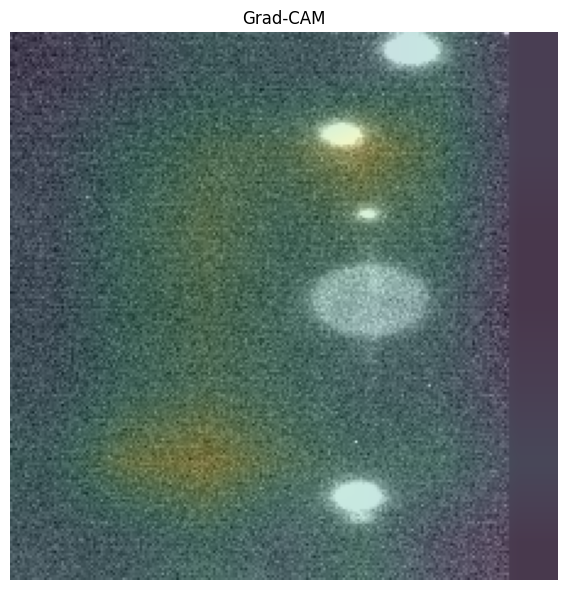

In [ ]:
# ── CONFIG ─────────────────────────────────────────────────────────────
IMAGE_PATH     = 'test_fits/uranus.Ks.158-reduc-clean-cut.fits'
WEIGHTS_PATH   = 'resnet18_kp.pth'
TARGET_LAYER   = 'layer4'      # pick any conv layer
IMG_SIZE       = 224
HEATMAP_ALPHA  = 0.25          # transparency for CAM overlay
# ────────────────────────────────────────────────────────────────────────

import cv2, torch, numpy as np, matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import ZScaleInterval
from torchvision import models
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mean  = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32, device=device)
std   = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32, device=device)

# ── Image utilities ────────────────────────────────────────────────────
def read_image(path):
    """Return Z-scaled RGB uint8 image (H×W×3)."""
    if path.lower().endswith('.fits'):
        with fits.open(path, memmap=False) as h:
            data = h[0].data.astype(np.float32)
        vmin, vmax = ZScaleInterval().get_limits(data)
        data = np.clip((data - vmin) / (vmax - vmin + 1e-6), 0, 1)
        img  = (data * 255).astype(np.uint8)
        img  = np.repeat(img[..., None], 3, axis=-1)
    else:
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    return img

def preprocess(img):
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    x   = torch.from_numpy(img).permute(2,0,1).float() / 255.
    x   = x.to(device)
    x   = (x - mean[:,None,None]) / std[:,None,None]
    return x.unsqueeze(0)  # (1,3,H,W)

# ── Build model that matches the checkpoint head ───────────────────────
def build_model(weights):
    ckpt   = torch.load(weights, map_location='cpu')
    net    = models.resnet18(weights=None)
    outdim = 6
    if any(k.startswith('fc.0.') for k in ckpt):        # Linear→Sigmoid head
        net.fc = nn.Sequential(nn.Linear(net.fc.in_features, outdim), nn.Sigmoid())
        post_sig = False
    else:                                               # Linear only
        net.fc = nn.Linear(net.fc.in_features, outdim)
        post_sig = True
    net.load_state_dict(ckpt, strict=False)
    return net.to(device).eval(), post_sig

# ── Grad-CAM helper ────────────────────────────────────────────────────
class GradCAM:
    def __init__(self, model, target_layer):
        self.model, self.layer = model, target_layer
        self.activ, self.grad = None, None

        def _forward_hook(module, inputs, output):
            self.activ = output.detach()

        def _backward_hook(module, grad_input, grad_output):
            self.grad = grad_output[0].detach()

        self.layer.register_forward_hook(_forward_hook)
        # full_backward_hook is the modern API; falls back if not present
        if hasattr(self.layer, 'register_full_backward_hook'):
            self.layer.register_full_backward_hook(_backward_hook)
        else:
            self.layer.register_backward_hook(_backward_hook)

    def __call__(self, x):
        x.requires_grad_()
        out = self.model(x)
        out.mean().backward()

        weights = self.grad.mean(dim=(2,3), keepdim=True)        # GAP
        cam = torch.relu((weights * self.activ).sum(1, keepdim=True))[0,0]

        cam = torch.nn.functional.interpolate(cam.unsqueeze(0).unsqueeze(0),
                                              size=(IMG_SIZE, IMG_SIZE),
                                              mode='bilinear',
                                              align_corners=False)[0,0]
        cam = (cam - cam.min()) / (cam.max() + 1e-8)
        return cam.cpu().numpy(), out.detach()

# ── Inference + Grad-CAM ───────────────────────────────────────────────
raw_img  = read_image(IMAGE_PATH)
x        = preprocess(raw_img)
model, need_sig = build_model(WEIGHTS_PATH)

cam_gen  = GradCAM(model, dict(model.named_modules())[TARGET_LAYER])
heatmap, preds = cam_gen(x)

if need_sig:
    preds = preds.sigmoid()                   # ensure 0-1 range

kps = preds.squeeze().cpu().numpy().reshape(3,2) * IMG_SIZE  # pixel coords

# ── Plot ────────────────────────────────────────────────────────────────
plt.figure(figsize=(6,6))
plt.imshow(cv2.resize(raw_img, (IMG_SIZE, IMG_SIZE)))
plt.imshow(heatmap, cmap='viridis', alpha=HEATMAP_ALPHA)
#plt.scatter(kps[:,0], kps[:,1], c='red', marker='x', s=80, linewidths=2)
#for i,(xp,yp) in enumerate(kps):
#    plt.text(xp+4, yp+4, f'{i+1}', color='red', fontsize=9)
plt.title('Grad-CAM')
plt.axis('off'); plt.tight_layout(); plt.show()


# BELOW is the old resnet-9

In [ ]:
# fits file + plotting
import torch, math, cv2, random
import pandas as pd
import numpy as np
from pathlib import Path
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
import matplotlib.pyplot as plt  # <-- for plotting

TRAIN_DIR = Path('train_fits')
TEST_DIR  = Path('test_fits')
CSV_TRAIN = Path('labels_train.csv')
CSV_TEST  = Path('labels_test.csv')

BATCH_SIZE   = 32
EPOCHS_HEAD  = 0
EPOCHS_FULL  = 20
LR           = 0.001
IMG_SIZE     = 224

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using", device)

# ─────────────────────────────── dataset class ───────────────────────────────
from astropy.io import fits          # ← NEW: read FITS images

class KPDataset(Dataset):
    def __init__(self, csv_file, root_dir, augment=False):
        self.df   = pd.read_csv(csv_file)
        self.root = Path(root_dir)
        self.aug  = augment

        # torchvision transforms expect a H×W×C NumPy array in RGB
        self.tfs  = transforms.Compose([
            transforms.ToTensor(),                     # (C,H,W) float32 0-1
            transforms.Resize((IMG_SIZE, IMG_SIZE)),   # ResNet18‐native size
            transforms.Normalize([0.485,0.456,0.406],  # ImageNet stats
                                 [0.229,0.224,0.225])
        ])

    # -------------------------------------------------------------------------
    @staticmethod
    def _read_fits(path: Path):
        """Load a FITS image ➔ 3-channel uint8 RGB array (H×W×3)."""
        with fits.open(path) as hdul:
            data = hdul[0].data.astype(np.float32)

        # handle NaNs / scale to 0-255
        data = np.nan_to_num(data, nan=0.0)
        data -= data.min()
        if data.max() > 0:
            data /= data.max()
        data = (data * 255).clip(0, 255).astype(np.uint8)

        # FITS is single-channel → replicate to fake RGB
        return np.stack([data, data, data], axis=-1)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        r        = self.df.iloc[idx]
        img_path = self.root / r['filename']

        # read image (FITS or anything OpenCV understands)
        if img_path.suffix.lower() == '.fits':
            img = self._read_fits(img_path)            # H×W×3 uint8
        else:                                          # fallback (PNG/JPG…)
            img = cv2.cvtColor(cv2.imread(str(img_path)),
                               cv2.COLOR_BGR2RGB)

        h, w = img.shape[:2]

        # key-points ➔ relative [0-1]
        kps = torch.tensor([
            r['x1']/w, r['y1']/h,
            r['x2']/w, r['y2']/h,
            r['x3']/w, r['y3']/h
        ], dtype=torch.float32)

        # simple colour jitter (still works on replicated RGB)
        if self.aug and random.random() < 0.5:
            img = cv2.convertScaleAbs(
                    img,
                    alpha=random.uniform(0.9, 1.1),
                    beta=random.randint(-10, 10))

        return self.tfs(img), kps

# ───────────────────────── dataloaders ──────────────────────────
train_ds = KPDataset(CSV_TRAIN, TRAIN_DIR, augment=True)
test_ds  = KPDataset(CSV_TEST , TEST_DIR , augment=False)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE,
                      shuffle=True,  num_workers=2, pin_memory=True)
test_dl  = DataLoader(test_ds , batch_size=BATCH_SIZE,
                      shuffle=False, num_workers=2, pin_memory=True)


def conv_bn(c_in, c_out, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(c_in, c_out, ks, stride, padding=ks//2, bias=False),
        nn.BatchNorm2d(c_out),
        nn.ReLU(inplace=True)
    )

class ResBlock(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.conv1 = conv_bn(c,c)
        self.conv2 = conv_bn(c,c)
    def forward(self,x): return x + self.conv2(self.conv1(x))

class ResNet9(nn.Module):
    def __init__(self, num_outputs=6):
        super().__init__()
        self.net = nn.Sequential(
            conv_bn(3, 64, ks=3, stride=1),
            conv_bn(64,128, ks=3, stride=2),
            ResBlock(128),
            conv_bn(128,256, ks=3, stride=2),
            ResBlock(256),
            conv_bn(256,512, ks=3, stride=2),
            ResBlock(512),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
        )
        self.head = nn.Linear(512, num_outputs)

    def forward(self,x): return self.head(self.net(x))

model = ResNet9().to(device)

def train_one_epoch(dl, model, optim, loss_fn):
    model.train()
    running = 0
    for x,y in tqdm(dl, leave=False):
        x,y = x.to(device), y.to(device)
        optim.zero_grad()
        pred = model(x)
        loss = loss_fn(pred,y)
        loss.backward()
        optim.step()
        running += loss.item()*x.size(0)
    return running/len(dl.dataset)

@torch.no_grad()
def evaluate(dl, model):
    model.eval()
    total_dist = 0; n_pts = 0
    for x,y in dl:
        x,y = x.to(device), y.to(device)
        pred = model(x).clamp(0,1)
        h,w = IMG_SIZE, IMG_SIZE
        pred_px = pred*torch.tensor([w,h,w,h,w,h],device=device)
        y_px    = y   *torch.tensor([w,h,w,h,w,h],device=device)
        dist = torch.sqrt(((pred_px - y_px).reshape(-1,3,2)**2).sum(-1)).mean(-1)
        total_dist += dist.sum().item()
        n_pts += dist.numel()
    return total_dist / n_pts

loss_fn = nn.MSELoss()

@torch.no_grad()
def evaluate_loss(dl, model, loss_fn):
    model.eval()
    total_loss = 0
    for x, y in dl:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        total_loss += loss.item() * x.size(0)
    return total_loss / len(dl.dataset)

# === TRACK LOSSES AND ERRORS ===
train_losses_head = []
train_losses_full = []
val_errors = []
val_losses = []

## === TRAIN HEAD ONLY ===
for p in model.net.parameters(): p.requires_grad = False
optim = torch.optim.Adam(model.head.parameters(), lr=LR)

for epoch in range(EPOCHS_HEAD):
    tr_loss = train_one_epoch(train_dl, model, optim, loss_fn)
    train_losses_head.append(tr_loss)
    print(f"[head] epoch {epoch+1}/{EPOCHS_HEAD} - train MSE: {tr_loss:.4f}")

# === FINE-TUNE FULL NETWORK ===
for p in model.net.parameters(): p.requires_grad = True
optim = torch.optim.Adam(model.parameters(), lr=LR/10)


for epoch in range(EPOCHS_FULL):
    tr_loss = train_one_epoch(train_dl, model, optim, loss_fn)
    train_losses_full.append(tr_loss)

    val_err = evaluate(test_dl, model)
    val_loss = evaluate_loss(test_dl, model, loss_fn)  # <--- Validation MSE loss

    val_errors.append(val_err)
    val_losses.append(val_loss)  # <--- Track it

    print(f"[full] epoch {epoch+1}/{EPOCHS_FULL} - train MSE: {tr_loss:.4f} - val MSE: {val_loss:.4f} - val pixel error: {val_err:.2f}")

# === FINAL EVALUATION ===
mean_pixel_err = evaluate(test_dl, model)
print(f"\n🔍 Mean Euclidean error on **test_fits**: {mean_pixel_err:.2f} pixels")

# === SAVE MODEL WEIGHTS ===
torch.save(model.state_dict(), 'resnet9_kp.pth')
print("Model weights saved to resnet9_kp.pth")

# === PLOT TRAINING AND VALIDATION CURVES ===
plt.figure(figsize=(10,5))

epochs_head = list(range(1, EPOCHS_HEAD+1))
epochs_full = list(range(EPOCHS_HEAD+1, EPOCHS_HEAD+EPOCHS_FULL+1))

plt.plot(epochs_head, train_losses_head, label='Train Loss (Head Only)')
plt.plot(epochs_full, train_losses_full, label='Train Loss (Fine-tune)')
plt.plot(epochs_full, val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.grid(True)
plt.show()


Using cuda


  0%|          | 0/53 [00:00<?, ?it/s]

[full] epoch 1/20 - train MSE: 0.0581 - val MSE: 0.0091 - val pixel error: 27.78


  0%|          | 0/53 [00:00<?, ?it/s]

[full] epoch 2/20 - train MSE: 0.0113 - val MSE: 0.0011 - val pixel error: 8.08


  0%|          | 0/53 [00:00<?, ?it/s]

[full] epoch 3/20 - train MSE: 0.0101 - val MSE: 0.0013 - val pixel error: 9.49


  0%|          | 0/53 [00:00<?, ?it/s]

[full] epoch 4/20 - train MSE: 0.0092 - val MSE: 0.0019 - val pixel error: 12.93


  0%|          | 0/53 [00:00<?, ?it/s]

[full] epoch 5/20 - train MSE: 0.0087 - val MSE: 0.0018 - val pixel error: 11.25


  0%|          | 0/53 [00:00<?, ?it/s]

[full] epoch 6/20 - train MSE: 0.0084 - val MSE: 0.0057 - val pixel error: 22.33


  0%|          | 0/53 [00:00<?, ?it/s]

[full] epoch 7/20 - train MSE: 0.0084 - val MSE: 0.0019 - val pixel error: 12.37


  0%|          | 0/53 [00:00<?, ?it/s]

[full] epoch 8/20 - train MSE: 0.0075 - val MSE: 0.0037 - val pixel error: 17.27


  0%|          | 0/53 [00:00<?, ?it/s]

KeyboardInterrupt: 

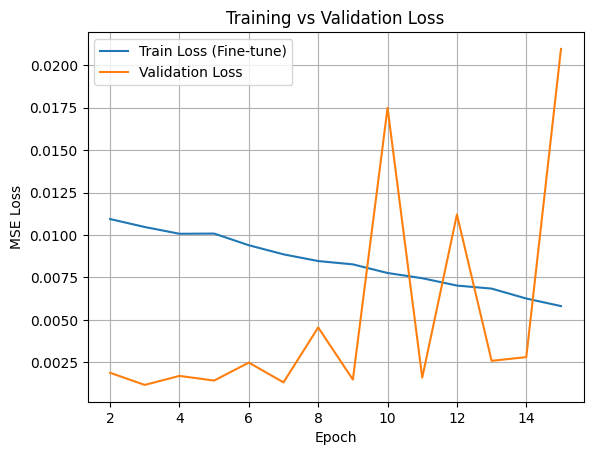

In [ ]:
plt.plot(epochs_full[1:15], train_losses_full[1:15], label='Train Loss (Fine-tune)')
plt.plot(epochs_full[1:15], val_losses[1:15], label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.grid(True)
plt.show()

In [ ]:
# === PLOT TRAINING AND VALIDATION CURVES ===
plt.figure(figsize=(10,5))

plt.plot(range(1, EPOCHS_HEAD+1), train_losses_head, label='Train Loss (Head Only)')
plt.plot(range(EPOCHS_HEAD+1, EPOCHS_HEAD+EPOCHS_FULL+1), train_losses_full, label='Train Loss (Fine-tune)')
# plt.plot(range(EPOCHS_HEAD+1, EPOCHS_HEAD+EPOCHS_FULL+1), val_errors, label='Val Pixel Error')

plt.xlabel('Epoch')
plt.ylabel('Loss / Error')
plt.legend()
plt.title('Training and Validation Curves')
plt.show()

NameError: name 'plt' is not defined

### Test the predicted center on an unseen image
change filename="uranus.Ks.203-reduc-clean-cut.fits" to the file name you prefer
this should be in the test folder

predicted (x,y) in original pixels:
  P1: (383.0, 267.1)
  P2: (342.3, 198.4)
  P3: (353.3, 850.0)


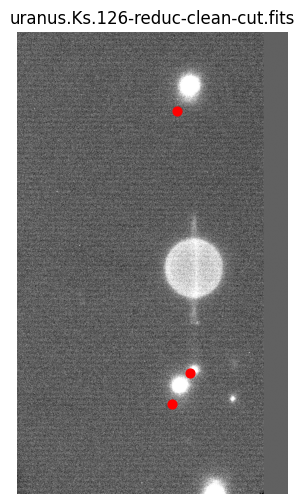

In [ ]:
#fits file
# ── Predict & plot one FITS image ─────────────────────────────────────────────
import torch, matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from astropy.io import fits
from torchvision import transforms
from astropy.visualization import ZScaleInterval

IMG_SIZE   = 224
MODEL_PATH = 'resnet9_kp.pth'  # or whatever you saved it as
TEST_DIR   = Path('test_fits') # folder with .fits images

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ── Load model (assuming ResNet9 is already defined in your session) ──────────
model = ResNet9().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# ── Choose image ──────────────────────────────────────────────────────────────
filename = "uranus.Ks.126-reduc-clean-cut.fits"  # or any other file you want
img_path = TEST_DIR / filename
assert img_path.exists(), f"{img_path} not found"

# ── Read and preprocess image ─────────────────────────────────────────────────
with fits.open(img_path) as hdul:
    data = hdul[0].data.astype(np.float32)

# Normalize 0–1
data -= data.min()
if data.max() > 0:
    data /= data.max()

h0, w0 = data.shape
img = np.stack([data]*3, axis=-1)  # shape: (H, W, 3)

tf = transforms.Compose([
    transforms.ToTensor(),                         # to C×H×W, float32
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

inp = tf(img).unsqueeze(0).to(device)  # shape: 1×3×224×224

# ── Predict ───────────────────────────────────────────────────────────────────
with torch.no_grad():
    pred = model(inp).clamp(0,1).cpu().squeeze()

coords = pred.numpy().reshape(3,2)
coords[:,0] *= w0    # scale x to original width
coords[:,1] *= h0    # scale y to original height

print("predicted (x,y) in original pixels:")
for i, (x,y) in enumerate(coords, 1):
    print(f"  P{i}: ({x:.1f}, {y:.1f})")

# ── Plot result ───────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6,6))
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(data)
ax.imshow(data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
ax.scatter(coords[:,0], coords[:,1], s=40, c='red')
ax.set_title(filename)
ax.axis('off')
plt.show()



## Couple with DAOPHOT

In [ ]:
pip install photutils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.9 MB/s eta 0:00:00


In [ ]:
def match_predictions_to_detections(filename, model, img_size=224, device='cpu'):
    """
    Matches each ResNet-predicted keypoint to the closest DAOStarFinder detection (1-to-1, no duplicates).

    Returns:
        List of tuples: [(pred_x, pred_y, dao_x, dao_y), ...]
    """
    import numpy as np
    from astropy.io import fits
    from astropy.stats import sigma_clipped_stats
    from photutils.detection import DAOStarFinder
    from torchvision import transforms
    import torch

    # --- Load FITS data ---
    with fits.open(filename) as hdul:
        data = hdul[0].data.copy()
        data = data[:, 70:700]

    data -= data.min()
    if data.max() > 0:
        data /= data.max()

    img = np.stack([data]*3, axis=-1)
    h_raw, w_raw = img.shape[:2]

    # --- Define transform inside the function ---
    img_tfs = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((img_size, img_size)),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    # --- Predict keypoints ---
    x = img_tfs(img).unsqueeze(0).to(device)
    model.eval()
    model.to(device)

    with torch.no_grad():
        pred = model(x).squeeze().clamp(0, 1)

    pred_xy = pred.cpu().numpy().reshape(-1, 2)
    pred_xy[:, 0] *= w_raw
    pred_xy[:, 1] *= h_raw

    # --- Detect sources using DAOStarFinder ---
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    daofind = DAOStarFinder(fwhm=5.0, threshold=15. * std)
    sources = daofind(data - median)

    if sources is None or len(sources) == 0:
        print("⚠️ No sources detected by DAOStarFinder.")
        return []

    dao_xy = np.vstack((sources['xcentroid'], sources['ycentroid'])).T

    # --- Match each prediction to the closest unused DAO detection ---
    matches = []
    used_indices = set()

    for pred_point in pred_xy:
        dists = np.linalg.norm(dao_xy - pred_point, axis=1)
        for idx in np.argsort(dists):
            if idx not in used_indices:
                used_indices.add(idx)
                dao_point = dao_xy[idx]
                matches.append((pred_point[0], pred_point[1], dao_point[0], dao_point[1]))
                break

    return matches



In [ ]:
def plot_matches_on_image(filename, matches):
    """
    Overlays the predicted points and DAO detections on the FITS image.
    Predicted points in red, DAO detections in cyan, with lines connecting them.
    """
    from astropy.io import fits

    with fits.open(filename) as hdul:
        data = hdul[0].data.copy()
        data = data[:, 70:700]  # same cut as in prediction

    plt.figure(figsize=(8, 8))
    plt.imshow(data, cmap='gray', origin='lower', vmin=np.percentile(data, 5), vmax=np.percentile(data, 99))

    for px, py, dx, dy in matches:
        plt.plot(px, py, 'ro', label='Predicted' if 'Predicted' not in plt.gca().get_legend_handles_labels()[1] else "")
        plt.plot(dx, dy, 'co', label='DAO Detected' if 'DAO Detected' not in plt.gca().get_legend_handles_labels()[1] else "")
        plt.plot([px, dx], [py, dy], 'y--', alpha=0.5)

    plt.title("Predictions vs DAO Matches")
    plt.xlabel("X pixel")
    plt.ylabel("Y pixel")
    plt.legend()
    plt.tight_layout()
    plt.show()


Predicted: (337.8, 265.9) ↔ DAO: (321.7, 274.5)
Predicted: (302.9, 199.9) ↔ DAO: (289.7, 240.8)
Predicted: (313.7, 851.1) ↔ DAO: (311.2, 906.3)


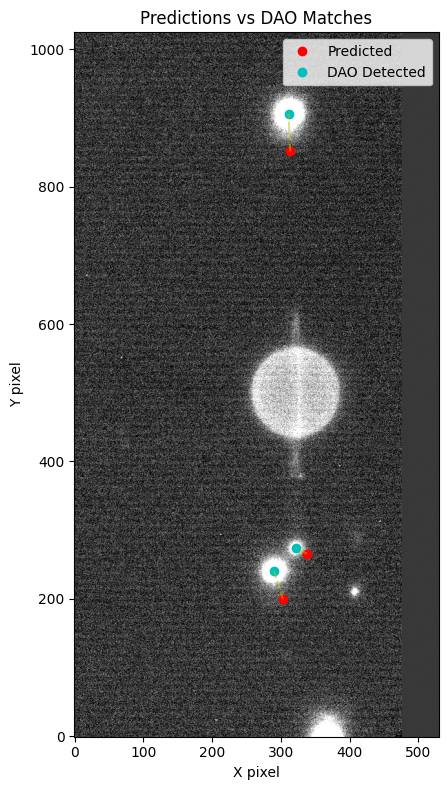

In [ ]:
matches = match_predictions_to_detections(
    "uranus/uranus.Ks.126-reduc-clean-cut.fits",
    model,
    device=device
)

for px, py, dx, dy in matches:
    print(f"Predicted: ({px:.1f}, {py:.1f}) ↔ DAO: ({dx:.1f}, {dy:.1f})")

plot_matches_on_image("uranus/uranus.Ks.126-reduc-clean-cut.fits", matches)


In [ ]:
!ls test_pngs

uranus.Ks.114-reduc-clean-cut.png  uranus.Ks.150-reduc-clean-cut.png
uranus.Ks.116-reduc-clean-cut.png  uranus.Ks.203-reduc-clean-cut.png
uranus.Ks.119-reduc-clean-cut.png  uranus.Ks.215-reduc-clean-cut.png
uranus.Ks.120-reduc-clean-cut.png  uranus.Ks.218-reduc-clean-cut.png
uranus.Ks.121-reduc-clean-cut.png  uranus.Ks.221-reduc-clean-cut.png
uranus.Ks.122-reduc-clean-cut.png  uranus.Ks.225-reduc-clean-cut.png
uranus.Ks.128-reduc-clean-cut.png  uranus.Ks.236-reduc-clean-cut.png
uranus.Ks.129-reduc-clean-cut.png  uranus.Ks.241-reduc-clean-cut.png
uranus.Ks.131-reduc-clean-cut.png  uranus.Ks.265-reduc-clean-cut.png


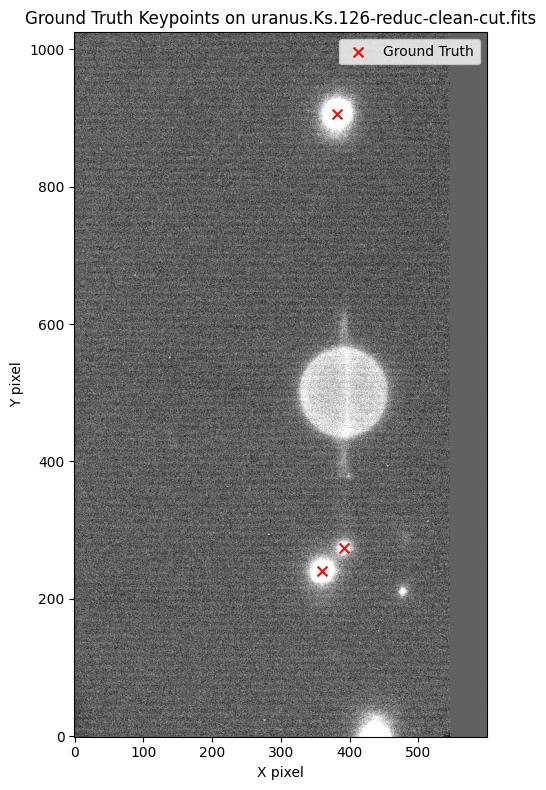

In [ ]:
# check that the coordinates from 3 key label are right

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from astropy.io import fits
from astropy.visualization import ZScaleInterval

# --- Settings ---
LABELS_FILE = Path('3_key_label_N10.txt')
IMAGE_DIR = Path('uranus') # Assuming the images are in a folder named 'uranus'
FILENAME_TO_PLOT = "uranus.Ks.126-reduc-clean-cut.fits" # Specify the filename you want to plot

# --- Read Labels ---
try:
    df_labels = pd.read_csv(LABELS_FILE, sep=' ')
except FileNotFoundError:
    print(f"Error: Labels file not found at {LABELS_FILE}")
    df_labels = None

if df_labels is not None:
    # --- Find the specified image's labels ---
    image_labels = df_labels[df_labels['filename'] == FILENAME_TO_PLOT]

    if image_labels.empty:
        print(f"Error: No labels found for {FILENAME_TO_PLOT} in {LABELS_FILE}")
    else:
        # Assuming there's only one row per filename in the labels file
        row = image_labels.iloc[0]

        # Extract keypoints
        # The columns might be named differently based on your file, adjust these names
        # For the current df_all structure: 'filename x1 y1 x2 y2 x3 y3'
        # Need to re-read the file with correct separator to get individual columns
        # Let's re-read with space separator as shown in the code
        df_labels_corrected = pd.read_csv(LABELS_FILE, sep=' ')
        image_labels_corrected = df_labels_corrected[df_labels_corrected['filename'] == FILENAME_TO_PLOT]

        if image_labels_corrected.empty:
             print(f"Error: No labels found for {FILENAME_TO_PLOT} with corrected parsing.")
        else:
            row_corrected = image_labels_corrected.iloc[0]

            # Extract keypoints assuming columns are 'x1', 'y1', 'x2', 'y2', 'x3', 'y3'
            # Check if these columns exist before accessing
            required_cols = ['x1', 'y1', 'x2', 'y2', 'x3', 'y3']
            if all(col in row_corrected.index for col in required_cols):
                coords = np.array([
                    [row_corrected['x1'], row_corrected['y1']],
                    [row_corrected['x2'], row_corrected['y2']],
                    [row_corrected['x3'], row_corrected['y3']]
                ])

                # --- Load FITS image ---
                img_path = IMAGE_DIR / FILENAME_TO_PLOT
                if not img_path.exists():
                    print(f"Error: Image file not found at {img_path}")
                else:
                    with fits.open(str(img_path)) as hdul:
                        data = hdul[0].data.copy()

                    # Optional: Apply the same cut as in other cells if needed
                    # data = data[:, 70:700]

                    # --- Plot ---
                    fig, ax = plt.subplots(figsize=(8, 8))
                    interval = ZScaleInterval()
                    vmin, vmax = interval.get_limits(data)
                    ax.imshow(data, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)

                    # Plot keypoints
                    ax.scatter(coords[:, 0], coords[:, 1], s=50, c='red', marker='x', label='Ground Truth')

                    ax.set_title(f"Ground Truth Keypoints on {FILENAME_TO_PLOT}")
                    ax.set_xlabel("X pixel")
                    ax.set_ylabel("Y pixel")
                    ax.legend()
                    plt.tight_layout()
                    plt.show()

            else:
                print("Error: Keypoint columns ('x1' through 'y3') not found in the labels file after parsing.")
                print("Available columns:", row_corrected.index.tolist())